In [1]:
import torch
from torch.backends import cudnn
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch.nn as nn
from typing import Union
from torchvision.ops.boxes import batched_nms


compound_coef = 4
threshold = 0.5
iou_threshold = 0.5
force_input_size = None
use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['wheat']

img_path = 'D:/Projects/Kaggle/Global-Wheat-Detction-Kaggle-2020/data/global-wheat-detection/test/2fd875eaa.jpg'#\

In [2]:
from edet4_inference_util import BBoxTransform, ClipBoxes
from edet4_inference_util import preprocess, invert_affine, postprocess

In [ ]:
import torch.nn as nn
import torch
import math
from torchvision.ops.boxes import nms as nms_torch

from edet4_inference_util import EfficientNet as EffNet

from edet4_inference_util import Anchors, BiFPN, Regressor, Classifier


class EfficientNet(nn.Module):
    """
    modified by Zylo117
    """

    def __init__(self, compound_coef, load_weights=False):
        super(EfficientNet, self).__init__()
        model = EffNet.from_pretrained(f'efficientnet-b{compound_coef}', load_weights)
        del model._conv_head
        del model._bn1
        del model._avg_pooling
        del model._dropout
        del model._fc
        self.model = model

    def forward(self, x):
        x = self.model._conv_stem(x)
        x = self.model._bn0(x)
        x = self.model._swish(x)
        feature_maps = []

        # TODO: temporarily storing extra tensor last_x and del it later might not be a good idea,
        #  try recording stride changing when creating efficientnet,
        #  and then apply it here.
        last_x = None
        for idx, block in enumerate(self.model._blocks):
            drop_connect_rate = self.model._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self.model._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

            if block._depthwise_conv.stride == [2, 2]:
                feature_maps.append(last_x)
            elif idx == len(self.model._blocks) - 1:
                feature_maps.append(x)
            last_x = x
        del last_x
        return feature_maps[1:]

# Efficient Net
class EfficientDetBackbone(nn.Module):
    def __init__(self, num_classes=80, compound_coef=0, load_weights=False, **kwargs):
        super(EfficientDetBackbone, self).__init__()
        self.compound_coef = compound_coef

        self.backbone_compound_coef = [0, 1, 2, 3, 4, 5, 6, 6]
        self.fpn_num_filters = [64, 88, 112, 160, 224, 288, 384, 384]
        self.fpn_cell_repeats = [3, 4, 5, 6, 7, 7, 8, 8]
        self.input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
        self.box_class_repeats = [3, 3, 3, 4, 4, 4, 5, 5]
        self.anchor_scale = [4., 4., 4., 4., 4., 4., 4., 5.]
        self.aspect_ratios = kwargs.get('ratios', [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)])
        self.num_scales = len(kwargs.get('scales', [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]))
        conv_channel_coef = {
            # the channels of P3/P4/P5.
            0: [40, 112, 320],
            1: [40, 112, 320],
            2: [48, 120, 352],
            3: [48, 136, 384],
            4: [56, 160, 448],
            5: [64, 176, 512],
            6: [72, 200, 576],
            7: [72, 200, 576],
        }

        num_anchors = len(self.aspect_ratios) * self.num_scales

        self.bifpn = nn.Sequential(
            *[BiFPN(self.fpn_num_filters[self.compound_coef],
                    conv_channel_coef[compound_coef],
                    True if _ == 0 else False,
                    attention=True if compound_coef < 6 else False)
              for _ in range(self.fpn_cell_repeats[compound_coef])])

        self.num_classes = num_classes
        self.regressor = Regressor(in_channels=self.fpn_num_filters[self.compound_coef], num_anchors=num_anchors,
                                   num_layers=self.box_class_repeats[self.compound_coef])
        self.classifier = Classifier(in_channels=self.fpn_num_filters[self.compound_coef], num_anchors=num_anchors,
                                     num_classes=num_classes,
                                     num_layers=self.box_class_repeats[self.compound_coef])

        self.anchors = Anchors(anchor_scale=self.anchor_scale[compound_coef], **kwargs)

        self.backbone_net = EfficientNet(self.backbone_compound_coef[compound_coef], load_weights)

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def forward(self, inputs):
        max_size = inputs.shape[-1]

        _, p3, p4, p5 = self.backbone_net(inputs)

        features = (p3, p4, p5)
        features = self.bifpn(features)

        regression = self.regressor(features)
        classification = self.classifier(features)
        anchors = self.anchors(inputs, inputs.dtype)

        return features, regression, classification, anchors

    def init_backbone(self, path):
        state_dict = torch.load(path)
        try:
            ret = self.load_state_dict(state_dict, strict=False)
            print(ret)
        except RuntimeError as e:
            print('Ignoring ' + str(e) + '"')


In [4]:
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)


(1024, 1024, 3)


In [9]:
import sys
sys.path.insert(1, '../models/EfficientDet')

In [10]:
from backbone import EfficientDetBackbone

In [5]:
model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

In [6]:
try:
    model.load_state_dict(torch.load('efficientdet-d4.pth'))
except:
    print('some weights might mis match')
model.requires_grad_(False)
model.eval()

some weights might mis match


EfficientDetBackbone(
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), groups=224, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(224, 224, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(224, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), groups=224, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(224, 224, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(224, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePad

In [39]:
compound_coef

4

In [13]:
if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

In [14]:
with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

In [24]:
out[0]['class_ids']

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

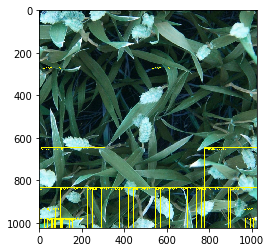

In [25]:
for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue

    for j in range(len(out[i]['rois'][:30])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])